# Spaceship Titanic Kaggle Challenge!

### Label Descriptions (for self reference)

- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## Preliminary Processing

### Make imports and configure

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

In [2]:
sns.set_theme(style='whitegrid')
sns.set_palette('viridis')

### Read in and inspect data

In [3]:
df = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
print(f'The data has {df.shape[0]} rows and {df.shape[1]} columns')

The data has 8693 rows and 14 columns


In [5]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
df.describe().T.sort_values(by='mean', ascending=False).style.background_gradient(cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.000000,458.077203,1611.489240,0.000000,0.000000,0.000000,76.000000,29813.000000
Spa,8510.000000,311.138778,1136.705535,0.000000,0.000000,0.000000,59.000000,22408.000000
VRDeck,8505.000000,304.854791,1145.717189,0.000000,0.000000,0.000000,46.000000,24133.000000
RoomService,8512.000000,224.687617,666.717663,0.000000,0.000000,0.000000,47.000000,14327.000000
ShoppingMall,8485.000000,173.729169,604.696458,0.000000,0.000000,0.000000,27.000000,23492.000000
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000


#### Splitting Cabin

In [8]:
def split_cabin(cabin):
    if not pd.isna(cabin):
        return pd.Series(cabin.split('/'), index=['Deck','Number', 'Side'])
    else:
        return pd.Series(dtype='object')

In [9]:
def apply_and_concat(df):
    cabin = df['Cabin'].apply(split_cabin)
    return pd.concat([df, cabin], axis=1)

In [10]:
df = apply_and_concat(df)
test = apply_and_concat(test)

#### Convert Data to Correct Type

In [11]:
def convert_dtype(df):

    df['VIP'] = df['VIP'].astype(bool)
    df['CryoSleep'] = df['CryoSleep'].astype(bool)
    df['Number'] = df['Number'].astype(float)
    
    return df

In [12]:
df = convert_dtype(df)
test = convert_dtype(test)

### Null Value Analysis

In [13]:
print(f'Total of {df.isna().sum().sum()} null values')

Total of 2501 null values


#### Column and Row Null Distribution

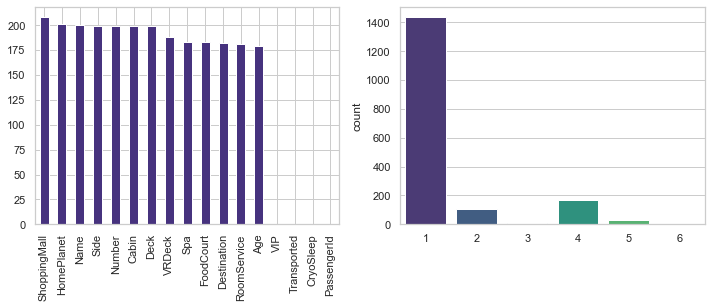

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

null_cols = df.isnull().sum().sort_values(ascending=False)
null_cols.plot(kind='bar', ax = ax1)
ax1.set_xlabel('')

null_rows = x=df.isnull().sum(axis=1)
sns.countplot(x=null_rows[null_rows!=0], ax=ax2)

plt.show()

## Exploratory Data Analysis

### Distribution of Target Variable

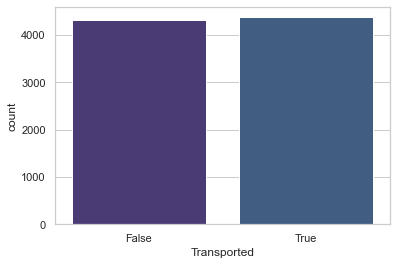

In [15]:
sns.countplot(x='Transported', data=df)
plt.show()

### Categorical Variables

#### Origin and Destinations

In [16]:
data = []
origins = list(df['HomePlanet'].dropna().unique())
destinations = list(df['Destination'].dropna().unique())

for origin in origins:
    for destination in destinations:
        temp = df[(df['HomePlanet'] == origin) & (df['Destination'] == destination)]
        row = [origin, destination, temp.shape[0]]
        data.append(row)
        # d[origin + ' -> ' + destination] = temp.shape[0]

In [17]:
trip_data = pd.DataFrame(data, columns=['Origin', 'Destination', 'Number of Trips'])

<AxesSubplot:xlabel='Origin', ylabel='Number of Trips'>

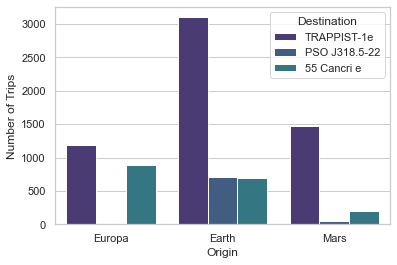

In [18]:
sns.barplot(x='Origin', y='Number of Trips', data=trip_data, hue='Destination')

#### Distribution of Categorical Values

In [19]:
cat_var = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
for col in cat_var:
    print(df[col].value_counts())
    print('\n')

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64


False    5439
True     3254
Name: CryoSleep, dtype: int64


TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64


False    8291
True      402
Name: VIP, dtype: int64


F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64


S    4288
P    4206
Name: Side, dtype: int64




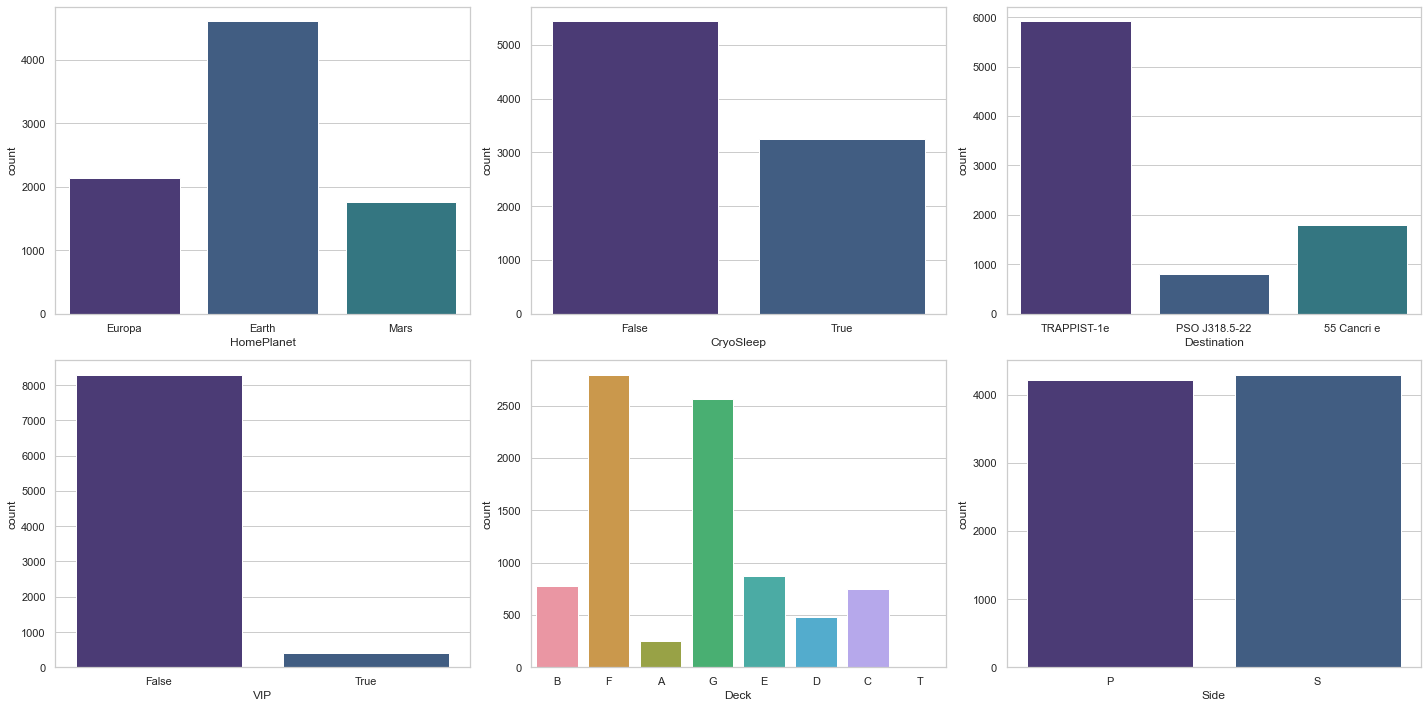

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(20,10))
axs = axs.flatten()

i = 0
for col in cat_var:
    sns.countplot(x=col, data=df, ax=axs[i])
    i+=1

plt.tight_layout()
# plt.delaxes(axs[7])

#### Which categories correlate to transportation?

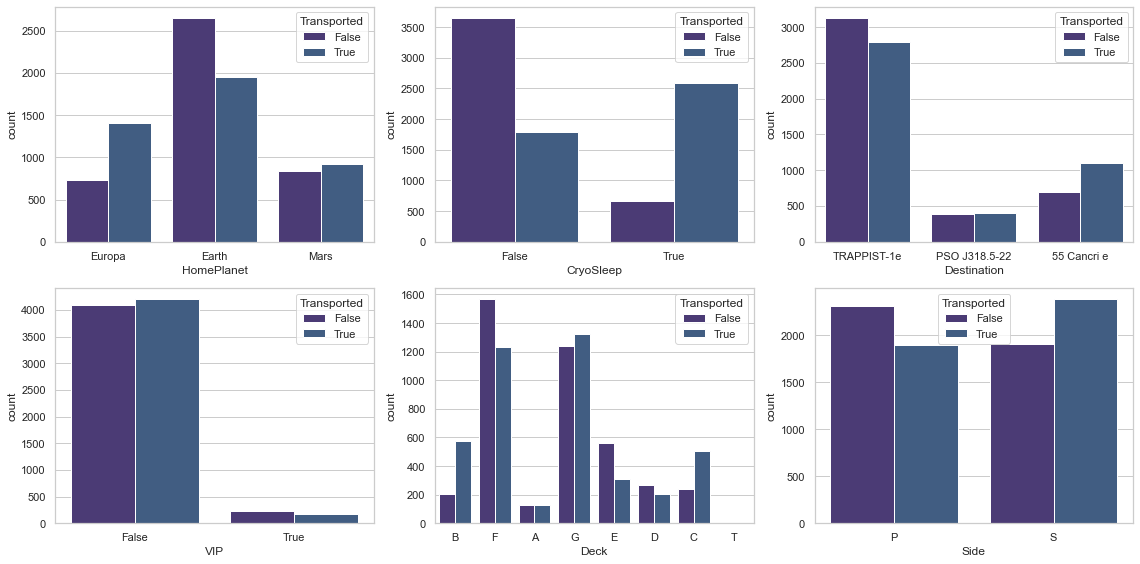

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
axs = axs.flatten()

i = 0
for col in cat_var[:6]:
    sns.countplot(x=col, data=df, ax=axs[i], hue='Transported')
    i+=1
    
plt.tight_layout()

- Europa have disproportionately more passengers being transported
- Passengers in Cryosleep are disproportionately transported
- Passengers departing for 55 Cancri e are disproportionately transported
- Passengers in decks B, G and C are more likely to be transported
- Passengers on Starboard more likely to be transported

### Continuous Variables

#### Distribution Of Spending

In [22]:
spending = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [23]:
df['TotalSpend'] = df[spending].sum(axis=1)

In [24]:
for spend in (spending + ['TotalSpend']):
    zeros = df[spend].value_counts()
    print(f'Number of 0 values in {spend} Spending is {zeros[0]} out of {zeros.sum()} or {(zeros[0]/zeros.sum())*100:.2f}%')

Number of 0 values in RoomService Spending is 5577 out of 8512 or 65.52%
Number of 0 values in FoodCourt Spending is 5456 out of 8510 or 64.11%
Number of 0 values in ShoppingMall Spending is 5587 out of 8485 or 65.85%
Number of 0 values in Spa Spending is 5324 out of 8510 or 62.56%
Number of 0 values in VRDeck Spending is 5495 out of 8505 or 64.61%
Number of 0 values in TotalSpend Spending is 3653 out of 8693 or 42.02%


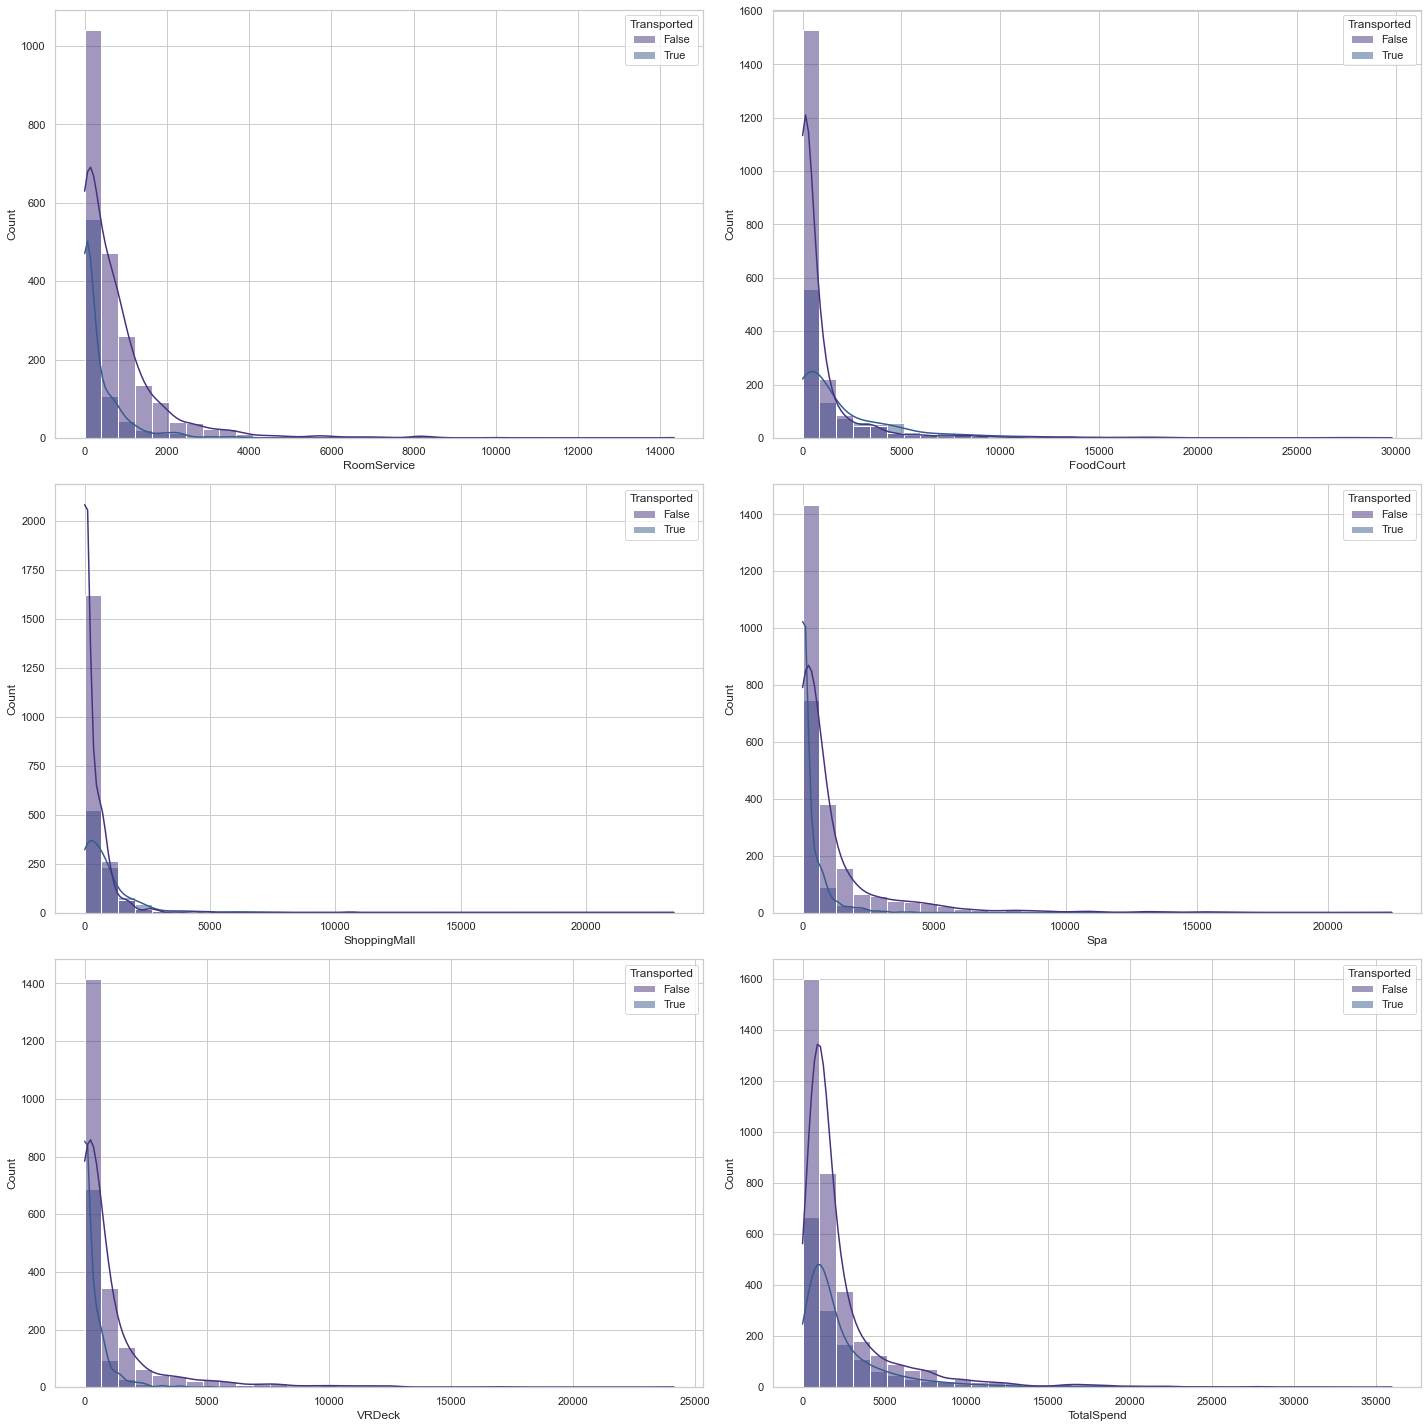

In [25]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))
axs = axs.flatten()

i = 0
for spend in (spending + ['TotalSpend']):
    x = df[df[spend] > 0]
    sns.histplot(x=x[spend], bins=35, kde=True, ax=axs[i], hue=x['Transported'])
    i+=1
    
plt.tight_layout()

#### Distribution Of Age

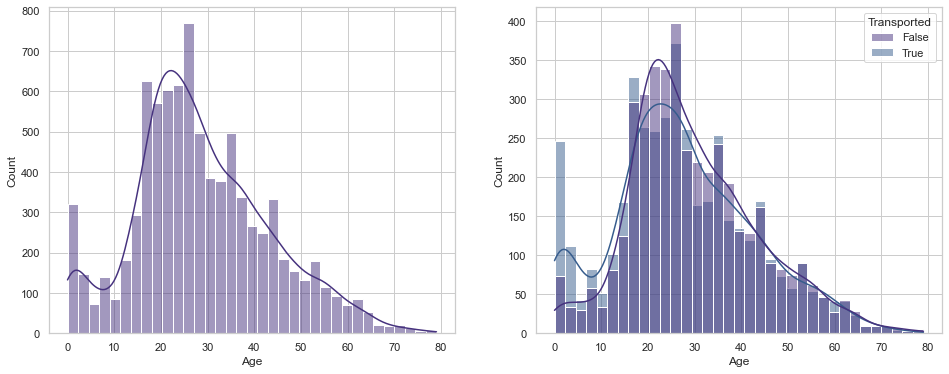

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
sns.histplot(x='Age', data=df, kde=True, bins=35, ax=ax1)
sns.histplot(x='Age', data=df, kde=True, bins=35, hue='Transported', ax=ax2)
plt.show()

#### Distribution of Cabin Number

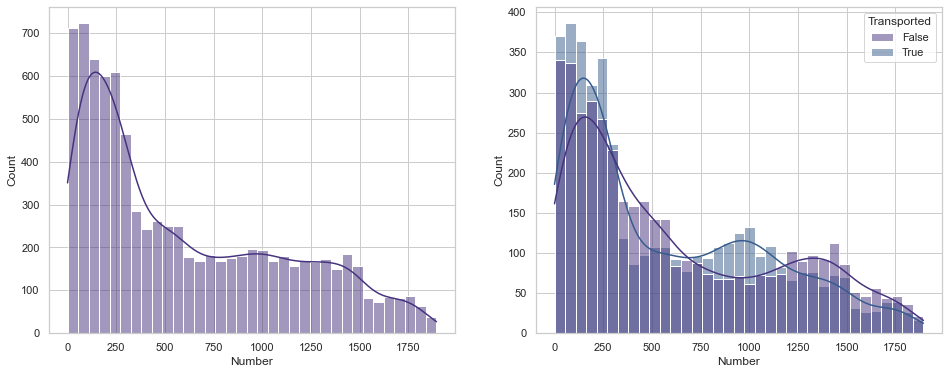

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
sns.histplot(x='Number', data=df, kde=True, bins=35, ax=ax1)
sns.histplot(x='Number', data=df, kde=True, bins=35, hue='Transported', ax=ax2)
plt.show()

### Correlation Matrix

<AxesSubplot:>

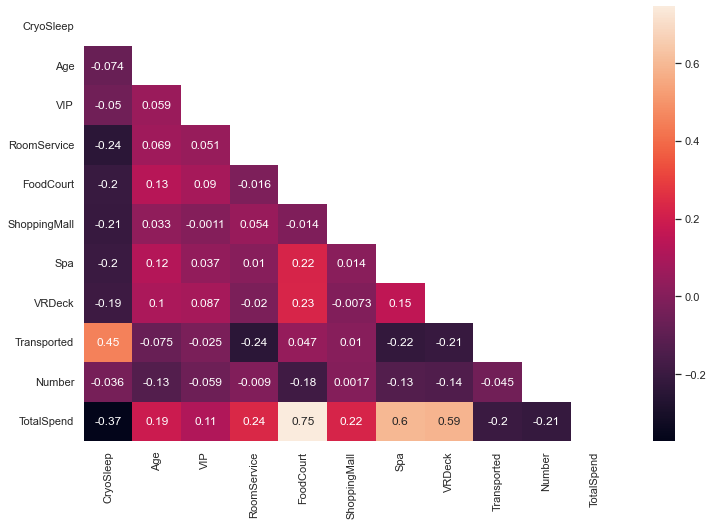

In [28]:
plt.figure(figsize=(12,8))
mask = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, mask=mask)

## Pre-Processing

In [29]:
# Save PassengerId Column

ids = test['PassengerId']

### Dropping Unneeded Columns

In [30]:
def drop_rows(df):
    if 'TotalSpend' in df.columns:
        return df.drop(columns=['PassengerId' ,'Name', 'Cabin', 'TotalSpend'])
    else:
        return df.drop(columns=['PassengerId' ,'Name', 'Cabin'])

In [31]:
df = drop_rows(df)
test = drop_rows(test)

### NA Removal

#### Continuous Variables

Use the median values for the spending variables (think they're all 0 which is reasonable) and the mean value for the age

In [32]:
def del_na_cont(df):
    for spend in spending:
        med = df[spend].median()
        # print(f'Median for {spend} is {med}')
        df[spend] = df[spend].fillna(med)
    
    mean_age = df['Age'].mean()
    # print(f'Mean of Ages is {mean_age:.2f}')
    df['Age'] = df['Age'].fillna(mean_age)
    
    return df

In [33]:
df = del_na_cont(df)
test = del_na_cont(test)

#### Categorical Variables and Cabin Number

Replace values by a weighted sampling of variables using np.choice

In [34]:
cat_var = cat_var + ['Number']

In [35]:
def del_na_cat(df):
    for var in cat_var:
        
        # Get the length of na columns
        length_of_na = len(df[df[var].isnull()])
        
        # Get the names of the variables
        var_list = df[var].dropna().unique()
        
        # Find the prior distribution we need for random assignment
        probs = list(df[var].value_counts()) / (df[var].value_counts().sum())
        
        # Choice method to randomly assign
        inserts = np.random.choice(var_list, length_of_na, p=probs)
        
        # Insert it into the dataframe with loc
        df.loc[df[var].isnull(), var] = np.random.choice(var_list, length_of_na, p=probs)
        
    return df

In [36]:
df = del_na_cat(df)
test = del_na_cat(test)

### Encoding Categorical Data

In [37]:
def encode(df):

    # Nominal Data
    df = pd.concat([df, pd.get_dummies(df['HomePlanet'], drop_first=True), 
                    pd.get_dummies(df['Destination'], drop_first=True),
                    pd.get_dummies(df['Deck'], drop_first=True)],
                axis=1)
    
    df.drop(columns=['HomePlanet', 'Destination', 'Deck'], inplace=True)
    
    # Binary Data
    df['CryoSleep'] = df['CryoSleep'].map({True: 1, False:0})
    df['VIP'] = df['VIP'].map({True: 1, False:0})
    df['Side'] = df['Side'].map({'S': 1, 'P': 0})
    
    # Target Variable
    if 'Transported' in df.columns:
        df['Transported'] = df['Transported'].map({True: 1, False:0})
    
    return df

In [38]:
df = encode(df)
test = encode(test)

## Model Building

In [39]:
X = df.drop(columns=['Transported'])
y = df['Transported']

### Splitting the Dataset

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Logistic Regression

In [41]:
model_logit = LogisticRegression(max_iter=1000).fit(X_train, y_train)

In [42]:
preds = model_logit.predict(X_test)

<AxesSubplot:>

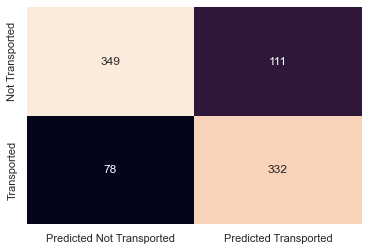

In [43]:
sns.heatmap(
pd.DataFrame(confusion_matrix(y_test, preds), 
             columns = ['Predicted Not Transported', 'Predicted Transported'],
             index=['Not Transported', 'Transported'])
, annot=True, fmt='g', cbar=False)

In [44]:
eval_df = pd.DataFrame(
            [accuracy_score(y_test, preds)] + list(precision_recall_fscore_support(y_test, preds, average='binary')), 
            index=['Accuracy','Precision', 'Recall', 'F-Score', 'Support'],
            columns=['Logistic Regression']
            ).T

In [45]:
eval_df

,Accuracy,Precision,Recall,F-Score,Support
Logistic Regression,0.782759,0.749436,0.809756,0.778429,NaN


### Neural Network

#### Hyperparameters

In [46]:
n_input = len(X_train.columns)
n_hidden = 32
n_classes = 2
batch_size = 256
learning_rate = 0.001
n_epochs = 300

#### Instantiate Dataloaders

In [47]:
X_train_tensor = torch.tensor(X_train.values)
y_train_tensor = torch.tensor(y_train.values)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

X_test_tensor = torch.tensor(X_test.values)
y_test_tensor = torch.tensor(y_test.values)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [48]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size,
                              shuffle=True
                            ) 

test_dataloader = DataLoader(test_dataset, 
                              batch_size=batch_size,
                              shuffle=False
                            ) 

#### Create Network

In [49]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, train_data):
        out = self.l1(train_data)
        out = self.relu(out)
        out = self.l2(out) 
        return out

#### Instantiate model, loss function and optimizer

In [50]:
model_nn = NeuralNet(n_input, n_hidden, n_classes)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_nn.parameters(), lr=learning_rate)

#### Training Loop

In [51]:
losses = []

for epoch in range(n_epochs):
    running_loss = 0
    
    for batch_no, (features, labels) in enumerate(train_dataloader):
        
        # forward 
        outputs = model_nn(features.float())
        loss = loss_fn(outputs, labels)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # adam step
        optimizer.step()
        
        # add 
        running_loss += loss.item()

        
    loss = running_loss / len(train_dataloader)
    losses.append(loss)
    
    if ((epoch + 1) % 10) == 0:
        print(f'epoch --> {epoch+1} | loss --> {loss}')
    
print('Finished Training')

epoch --> 10 | loss --> 0.779155014022704
epoch --> 20 | loss --> 0.6106137537187145
epoch --> 30 | loss --> 0.5494272305119422
epoch --> 40 | loss --> 0.5428339954345457
epoch --> 50 | loss --> 0.5511052214330242
epoch --> 60 | loss --> 0.4988816745819584
epoch --> 70 | loss --> 0.5185490010246154
epoch --> 80 | loss --> 0.5200536731750734
epoch --> 90 | loss --> 0.5137064937622317
epoch --> 100 | loss --> 0.47481114537485186
epoch --> 110 | loss --> 0.5004187082090685
epoch --> 120 | loss --> 0.45659795691890104
epoch --> 130 | loss --> 0.4786981882587556
epoch --> 140 | loss --> 0.48625961330629164
epoch --> 150 | loss --> 0.4584843929736845
epoch --> 160 | loss --> 0.4456863768639103
epoch --> 170 | loss --> 0.4342587474853762
epoch --> 180 | loss --> 0.45076744691018134
epoch --> 190 | loss --> 0.4735432622894164
epoch --> 200 | loss --> 0.4492093651525436
epoch --> 210 | loss --> 0.4519688525507527
epoch --> 220 | loss --> 0.46319555178765326
epoch --> 230 | loss --> 0.4256818717

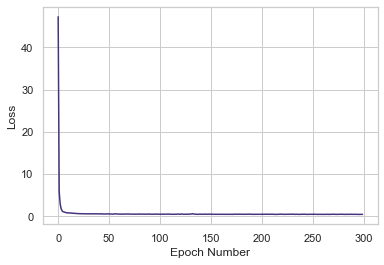

In [52]:
plt.plot(range(n_epochs), losses)
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

#### Evaluate

In [53]:
test_output = model_nn(X_test_tensor.float())
_, preds = torch.max(test_output, 1)
acc = accuracy_score(y_test, preds)

eval_df.loc['Neural Network'] = [acc] + list(precision_recall_fscore_support(y_test, preds, average='binary'))

<AxesSubplot:>

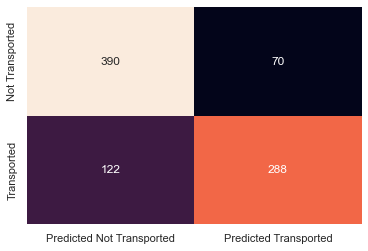

In [54]:
sns.heatmap(
pd.DataFrame(confusion_matrix(y_test, preds), 
             columns = ['Predicted Not Transported', 'Predicted Transported'],
             index=['Not Transported', 'Transported'])
, annot=True, fmt='g', cbar=False)

In [55]:
eval_df

,Accuracy,Precision,Recall,F-Score,Support
Logistic Regression,0.782759,0.749436,0.809756,0.778429,NaN
Neural Network,0.779310,0.804469,0.702439,0.750000,NaN


#### Prep for Submission

In [56]:
test_scores = model_nn(torch.tensor(test.values).float())
_, test_labels = torch.max(test_scores, 1)

## Submission

In [57]:
sub_logistic = pd.DataFrame([
                ids,
                model_logit.predict(test).astype(bool)],
                index = ['PassengerId', 'Transported']
            ).T

In [58]:
sub_logistic.to_csv('submissions/logit.csv', index=False)

In [59]:
sub_nn = pd.DataFrame([
        ids,
        test_labels.numpy().astype(bool)],
        index = ['PassengerId', 'Transported']
    ).T

In [60]:
sub_nn.to_csv('submissions/nn.csv', index=False)